# VGG

This notebook is for the blog: [VGG: Deep but Simple](https://derekzhouai.github.io/posts/building-vgg-for-mnist/)

## Model Architecture

In [1]:
import torch.nn as nn

class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs):
        super().__init__()
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            in_channels = out_channels
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [2]:
class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            # Layer #1: 1 (convolutional layer + ReLU) + MaxPool
            VGGBlock(1, 64, 1),      # 1x224x224 → 64x112x112

            # Layer #2: 1 (convolutional layer + ReLU) + MaxPool
            VGGBlock(64, 128, 1),    # 64x112x112 → 128x56x56

            # Layer #3: 2 (convolutional layers + ReLU) + MaxPool
            VGGBlock(128, 256, 2),   # 128x56x56 → 256x28x28

            # Layer #4: 2 (convolutional layers + ReLU) + MaxPool
            VGGBlock(256, 512, 2),   # 256x28x28 → 512x14x14

            # Layer #5: 2 (convolutional layers + ReLU) + MaxPool
            VGGBlock(512, 512, 2),   # 512x14x14 → 512x7x7

            nn.Flatten(),            # 512x7x7 → 25088

            # Layer #6:
            nn.Linear(25088, 4096),  # 25088 → 4096
            nn.ReLU(),
            nn.Dropout(0.5),

            # Layer #7:
            nn.Linear(4096, 4096),  # 4096 → 4096
            nn.ReLU(),
            nn.Dropout(0.5),

            # Layer #8:
            nn.Linear(4096, num_classes), # 4096 → 10
        )

    def forward(self, x):
        return self.net(x)

In [3]:
class RatioVGG11(nn.Module):
    def __init__(self, num_classes=10, ratio=1):
        super().__init__()
        self.net = nn.Sequential(
            # Layer #1: 1 (convolutional layer + ReLU) + MaxPool
            VGGBlock(1, 64 // ratio, 1),      # 1x224x224 → (64//ratio)x112x112

            # Layer #2: 1 (convolutional layer + ReLU) + MaxPool
            VGGBlock(64 // ratio, 128 // ratio, 1),    # (64//ratio)x112x112 → (128//ratio)x56x56

            # Layer #3: 2 (convolutional layers + ReLU) + MaxPool
            VGGBlock(128 // ratio, 256 // ratio, 2),   # (128//ratio)x56x56 → (256//ratio)x28x28

            # Layer #4: 2 (convolutional layers + ReLU) + MaxPool
            VGGBlock(256 // ratio, 512 // ratio, 2),   # (256//ratio)x28x28 → (512//ratio)x14x14

            # Layer #5: 2 (convolutional layers + ReLU) + MaxPool
            VGGBlock(512 // ratio, 512 // ratio, 2),   # (512//ratio)x14x14 → (512//ratio)x7x7

            nn.Flatten(),            # (512//ratio)x7x7

            # Layer #6:
            nn.Linear((512 // ratio) * 7 * 7, 4096),  # (512//ratio)x7x7 → 4096
            nn.ReLU(),
            nn.Dropout(0.5),

            # Layer #7:
            nn.Linear(4096, 4096),  # 4096 → 4096
            nn.ReLU(),
            nn.Dropout(0.5),

            # Layer #8:
            nn.Linear(4096, num_classes), # 4096 → 10
        )

    def forward(self, x):
        return self.net(x)

## Model Training

### Preparing the Data

In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def get_data_loaders(batch_size=128):
    transform = transforms.Compose([
        transforms.Resize(224),    # Upscale 28x28 → 224x224
        transforms.ToTensor()
    ])

    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader

In [5]:
train_loader, test_loader = get_data_loaders(batch_size=128)
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of test samples: {len(test_loader.dataset)}")

Number of training samples: 60000
Number of test samples: 10000


In [6]:
X, y = next(iter(train_loader))
print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

X.shape: torch.Size([128, 1, 224, 224])
y.shape: torch.Size([128])


### Training Loop

In [7]:
import torch

def evaluate(model, loader, loss, device):
    model.eval()
    total_loss, total_correct, total_num = 0.0, 0, 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            
            y_hat = model(X)
            l = loss(y_hat, y)

            total_loss += l.item() * X.size(0)
            total_correct += (y_hat.argmax(dim=1) == y).sum().item()
            total_num += X.size(0)
            
    return total_loss / total_num, total_correct / total_num

In [8]:
def train(model, num_epochs, batch_size, lr, device):
    model.to(device)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()

    train_loader, test_loader = get_data_loaders(batch_size)

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct, total_num = 0.0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
        
            optimizer.zero_grad()
            y_hat = model(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()

            total_loss += l.item() * X.size(0)
            total_correct += (y_hat.argmax(dim=1) == y).sum().item()
            total_num += X.size(0)

        train_loss = total_loss / total_num
        train_acc = total_correct / total_num

        test_loss, test_acc = evaluate(model, test_loader, loss, device)
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train => Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Test => Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

In [9]:
device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)
# To make sure the code runs in a reasonable time, we use a reduced model size with ratio=4
model = RatioVGG11(ratio=4)
num_epochs = 10
batch_size = 128
lr = 0.1

train(model, num_epochs, batch_size, lr, device)

Epoch 1/10: Train => Loss: 2.3029, Acc: 0.0985 | Test => Loss: 2.3027, Acc: 0.1000
Epoch 2/10: Train => Loss: 2.3029, Acc: 0.0985 | Test => Loss: 2.3026, Acc: 0.1000
Epoch 3/10: Train => Loss: 2.3029, Acc: 0.0986 | Test => Loss: 2.3027, Acc: 0.1000
Epoch 4/10: Train => Loss: 2.3020, Acc: 0.1068 | Test => Loss: 2.2931, Acc: 0.3068
Epoch 5/10: Train => Loss: 1.6085, Acc: 0.4029 | Test => Loss: 0.6376, Acc: 0.7594
Epoch 6/10: Train => Loss: 0.4803, Acc: 0.8191 | Test => Loss: 0.4554, Acc: 0.8296
Epoch 7/10: Train => Loss: 0.3516, Acc: 0.8679 | Test => Loss: 0.3827, Acc: 0.8525
Epoch 8/10: Train => Loss: 0.3009, Acc: 0.8868 | Test => Loss: 0.3206, Acc: 0.8800
Epoch 9/10: Train => Loss: 0.2697, Acc: 0.8979 | Test => Loss: 0.3494, Acc: 0.8677
Epoch 10/10: Train => Loss: 0.2434, Acc: 0.9091 | Test => Loss: 0.2726, Acc: 0.9015


## Model Testing

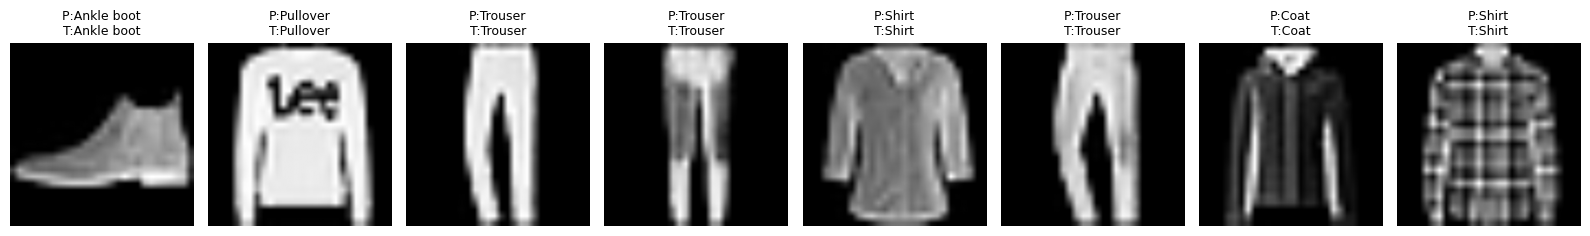

In [10]:
import torch
import matplotlib.pyplot as plt

# FashionMNIST class names
FASHION_CLASSES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

def show_fashionmnist_preds(model, test_loader, device, n=8):
    """
    Show n FashionMNIST test images with predicted and true labels.
    """
    model.to(device)
    model.eval()
    with torch.no_grad():
        X, y = next(iter(test_loader))
        X, y = X[:n], y[:n]
        pred = model(X.to(device)).argmax(1).cpu()

    plt.figure(figsize=(2*n, 2.6))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        img = X[i].squeeze().cpu()
        plt.imshow(img, cmap="gray")
        p_idx, t_idx = pred[i].item(), y[i].item()
        plt.title(f"P:{FASHION_CLASSES[p_idx]}\nT:{FASHION_CLASSES[t_idx]}", fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_fashionmnist_preds(model, test_loader, device, n=8)